# Loop state inference for TetO array insertion in mESCs

For this analysis, we use the data from Mach et al (2022). The data analyzed in this notebook are the 1B1 0min (wild type) and 1B1 120min (RAD21 depleted).

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import traceHMM

In [2]:
%reload_ext autoreload
%autoreload 2

### Fit with localization errors

In [3]:
path = "../../mach_et_al_2023/two_colors"
write = "../mach_data_cleaned"
files = []
for f in os.listdir(path):
    if f != ".DS_Store":
        id_line = "_".join(f.split("_")[3:5])
        files.append([id_line, os.path.join(path, f)])
files = pd.DataFrame(files, columns=["name", "f"])
if not os.path.exists(write):
    os.mkdir(write)
for name, df in files.groupby("name"):
    cc_df = pd.concat([pd.read_csv(f) for f in df["f"]])
    cc_df = cc_df.rename({"uniqueid":"id", "frame":"t"}, axis=1)
    cc_df = cc_df.astype({"t":"int64"})
    if write is not None:
        if not os.path.exists(write):
            os.mkdir(write)
        write_path = os.path.join(write, f"{name}.tsv")
        cc_df.to_csv(write_path, sep="\t", index=False)

In [4]:
os.listdir(write)

['1A2_120min.tsv',
 '1F4_120min.tsv',
 '1B1_120min.tsv',
 '1A2_0min.tsv',
 '1F4_0min.tsv',
 '1B1_0min.tsv']

In [5]:
data_1b1_0 = pd.read_csv(os.path.join(write, "1B1_0min.tsv"), sep="\t")
X0 = traceHMM.func.long_to_tensor(data_1b1_0, id_col="id", t_col="t", val_cols=["x", "y", "z"])
data_1b1_120 = pd.read_csv(os.path.join(write, "1B1_120min.tsv"), sep="\t")
X120 = traceHMM.func.long_to_tensor(data_1b1_120, id_col="id", t_col="t", val_cols=["x", "y", "z"])

In [6]:
data_1b1_120[["x", "y", "z"]].var(axis=0)

x    0.038176
y    0.038792
z    0.102151
dtype: float64

In [7]:
data_1b1_120["distance"].mean()

0.3742835648481378

In [8]:
exp_dist = np.array([0.1, 0.2, 0.4])
var_ls = exp_dist**2/3
dist_params = tuple([{"cov":np.identity(3)*var_ls[i]} for i in range(3)])
tm = traceHMM.TraceModel(
    X=X0, Pm=np.array([
        [-1, -1,  0],
        [-1, -1, -1],
        [ 0, -1, -1]
    ]),
    dist_params=dist_params,
    dist_type=traceHMM.model.multivariate_normal,
    update_dist_params=["err"]
)
tm.fit(600)

Converged at iteration 50


In [9]:
tm._dist_params[0]["err"]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.00023056, 0.        ],
       [0.        , 0.        , 0.0349791 ]])

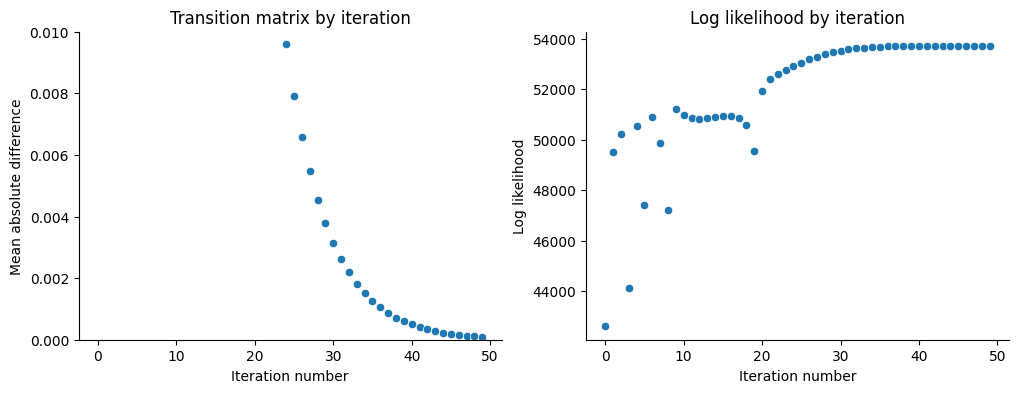

In [10]:
ig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(tm.convergence, ax=axes[0])
axes[0].set(
    xlabel="Iteration number", ylabel="Mean absolute difference",
    title="Transition matrix by iteration", ylim=(0, 0.01)
)
sns.scatterplot(tm.lklhd, ax=axes[1])
axes[1].set(
    xlabel="Iteration number", ylabel="Log likelihood",
    title="Log likelihood by iteration"
)
plt.show()

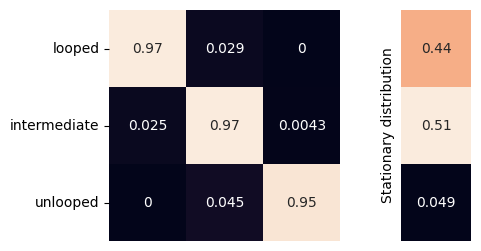

In [11]:
fig = traceHMM.plot.plot_transition_matrix(tm.P)

In [12]:
counts = np.unique(tm.decode(), return_counts=True)[1]
print(f"1B1 0min Loop fraction: {np.round(counts[0]/sum(counts)*100, 2)}%")
counts = np.unique(tm.decode(X120), return_counts=True)[1]
print(f"1B1 120min Loop fraction: {np.round(counts[0]/sum(counts)*100, 2)}%")

1B1 0min Loop fraction: 38.25%
1B1 120min Loop fraction: 3.87%


In [13]:
print(f"Average loop life time: {round(tm.avg_loop_life/2, 2)} min")

Average loop life time: 17.43 min
